In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

print("Running on PyMC3 v{}".format(pm.__version__))
print("Running on arviz v{}".format(az.__version__))


# pip uninstall arviz
# pip install arviz==0.8.3

Running on PyMC3 v5.7.2
Running on arviz v0.16.1


# Моделирование с использованием линейной регрессии


Сегодня мы рассмотрим одну из самых распространенных моделей - линейную модель.

Мы рассмотрим следующие линейные модели:
* простую линейную регрессию;
* робастную линейную регрессию;
* иерархическую линейную регрессию;
* полиномиальную линейную регрессию;
* множественную линейную регрессию.

## Простая линейная регрессия

Многие задачи в науке, технике и бизнесе могут быть представлены в следующей форме. Имеется переменная $x$, необходимо смоделировать или спрогнозировать переменную $y$. Здесь важно, что эти переменные объединены в пары, то есть $\{(x_1, y_1), (x_2, y_2), (x_3, y_3), ..., (x_n, y_n)\}$. В самом простом случае, известном под названием простой линейной регрессии, обе переменные $x$ и $y$ являются одномерными (линейными) непрерывными случайными переменными. <br>
Под непрерывностью подразумевается представление значений переменных с помощью действительных чисел (тип float). Под непрерывностью подразумевается представление значений переменных с помощью действительных чисел (тип float). <br>
Поэтому при использовании библиотеки NumPy переменные $x$ и $y$ представляются в виде одномерных массивов. Поскольку это наиболее обобщенная модель, переменные обозначаются соответствующими именами. 
Переменную $y$ называют зависимой, прогнозируемой или выходной переменной, а переменная $x$ именуется независимой, прогнозирующей или входной переменной. Если $X$ является матрицей (то есть имеется набор различных переменных), то такой вариант называют множественной линейной регрессией. 

Используя терминологию машинного обучения, мы говорим о задаче регрессии как о примере обучения с учителем (supervised learning). В рабочей среде машинного обучения задача регрессии возникает, когда необходимо обучение процедуре отображения $X$ в $y$, при этом $y$ является непрерывной переменной.
В машинном обучению обычно говорится о признаках (features) вместо переменных. Считаем, что процесс обучения управляется учителем, потому что знаем значения пар $X\to y$, то есть в определенном смысле нам известен правильный ответ. <br>
Все последующие вопросы относятся к тому, как обобщить эти наблюдения (или этот набор данных) для любого возможного будущего наблюдения, то есть для ситуации, когда известно значение $X$, но неизвестно значение $y$.

### Вероятностная модель линейной регрессии

Итак, Вам должно быть уже известно как записывается самое простое уравнение линейной регрессии:
$$y_i = \alpha + x_i \beta$$
Данное уравнение сообщает о существовании линейной зависимости между переменной $x$ и переменной $y$. <br>
Параметр $\beta$ управляет углом наклона графика этой линейной зависимости, следовательно, интерпретируется как величина изменения переменной $y$ по отношению к изменению величины переменной $x$. <br>
Другой параметр $\alpha$ известен под названием отсекаемого отрезка и сообщает значение $y_i$ при $x_i = 0$. Графически отсекаемый отрезок представляет значение $y_i$ в точке пересечения линейным графиком оси $y$.

Существует несколько методов подбора параметров для линейной модели. 

Одним из таких методов является метод наименьших квадратов, который возвращает значения $\alpha$ и $\beta$, дающие наименьшую среднюю квадратичную ошибку между наблюдаемым значением $y$ и прогнозируемым значением $\hat y$. Выраженная таким способом задача оценки $\alpha$ и $\beta$ является задачей оптимизации, то есть задачей, в которой выполняются попытки найти минимум или максимум некоторой функции.

Альтернативой методу оптимизации является генерация полностью вероятностной модели. <br>
Вероятностный подход дает несколько преимуществ: можно получить наилучшие значения $\alpha$ и $\beta$ (аналогичные полученным оптимизационными методами) вместе с оценкой неопределенности, присущей значениям этих параметров. Методы оптимизации требуют дополнительной работы по получению и подтверждению этой информации. Кроме того, вероятностный подход, особенно при использовании таких инструментальных средств, как библиотека PyMC3, предоставляет большую гибкость в адаптации моделей к решению конкретных задач.

При вероятностном подходе модель линейной регрессии можно выразить следующей формулой:
$$ y \sim \mathcal{N} (\mu = \alpha+ x\beta, \varepsilon) $$
Таким образом, вектор данных y определяется нормальным распределением
со средним значением $\alpha+ x\beta$ и стандартным отклонением $\varepsilon$.

Фактически, модель линейной регрессии – это расширение гауссовой модели, где среднее значение не оценивается напрямую, а вычисляется как линейная функция прогнозирующей переменной и некоторых дополнительных параметров. 

Поскольку нам неизвестны значения $\alpha$, $\beta$ и $\varepsilon$, необходимо установить для них априорные распределения. В общем случае разумным выбором является следующий:
$$\alpha  \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) $$
$$\beta  \sim \mathcal{N}(\mu_\beta, \sigma_\beta) $$
$$\varepsilon \sim |\mathcal{N}(0,\sigma_\varepsilon)|$$
Основные принципы назначения переменных: 
* $\alpha$, для  априорного распределения данного параметра  можно использовать самое простое нормальное распределение с установкой $\mu_\alpha=0$, а для $\sigma_\alpha$ относительно большого значения, чтобы масштабировать данные. В общем случае нам неизвестна возможная точка пересечения (отрезок отсечения), поэтому в разных задачах это значение может значительно изменяться в зависимости от конкретной модели. 
* $\beta$, поскольку данный параметр характеризует угол наклона, то, возможно, проще понять его основной смысл по сравнению с отсекаемым отрезком. Во многих задачах предварительно известен, по крайней мере, знак угла наклона, например можно ожидать, что переменная, характеризующая вес (массу), в среднем увеличивается вместе с ростом значения переменной, определяющей рост. 
* для параметра $\varepsilon$ можно определить значение $\sigma_\varepsilon$, большее по сравнению со значением переменой $y$, например в десять раз большее значение для стандартного отклонения. 

Эти весьма неопределенные предварительные условия обеспечивают чрезвычайно малое воздействие априорного распределения на апостериорное распределение, которое с легкостью компенсируется данными.

Вспомним, что если наше априорное распределение  оказывает наименьшее влияние на анализ, то такие неинформативные априорные распределения называю плоскими.

Необходимо отметить также, что точечная оценка, получаемая с использованием метода наименьших квадратов, согласовывается с оценкой апостериорного максимума (maximum a posteriori – MAP) (модой апостериорного распределения), полученной из байесовской простой линейной регрессии с плоскими априорными распределениями.

Альтернативой для задания $\varepsilon$ может являться равномерное распределение и полураспределение Коши. Часто в работах отмечают, что полураспределение Коши  успешно работает как эффективное априорное распределение регуляризации переменных.
При необходимости применения весьма жестко ограниченных априорных распределений, сконцентрированных около некоторого конкретного значения, то для стандартного отклонения, можно воспользоваться гамма-распределением.

Давайте представим модель линейной  регрессии в виде диаграммы:
 ![](01-LinModel.png)

Сгенерируем данные для вероятностной модели.

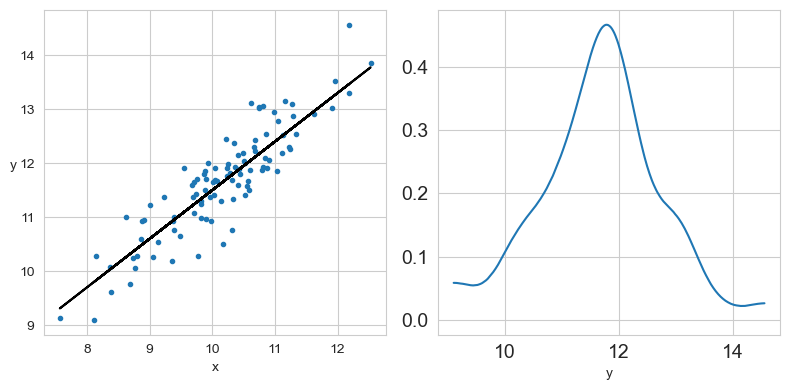

In [4]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)  # кстати это значение может стать проблемой
y_real = alpha_real + beta_real * x 
y = y_real + eps_real

# можно отцентровать данные
# x = x - x.mean()

# или стандартизовать данные (привет StandartScaler)
# x = (x - x.mean())/x.std()
# y = (y - y.mean())/y.std()


_, ax = plt.subplots(1,2, figsize=(8, 4)) 
ax[0].plot(x, y, 'C0.') 
ax[0].set_xlabel('x') 
ax[0].set_ylabel('y', rotation=0) 
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1]) 
ax[1].set_xlabel('y') 
plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.109,0.482,1.220,3.031,0.010,0.007,2380.0,2710.0,1.0
β,0.941,0.047,0.855,1.032,0.001,0.001,2378.0,2869.0,1.0
ε,0.450,0.033,0.392,0.514,0.001,0.000,3427.0,2958.0,1.0


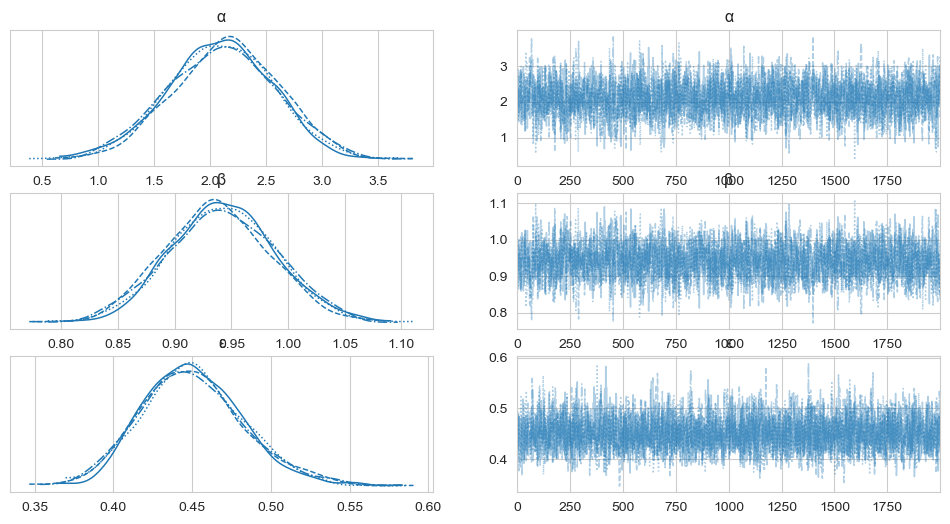

In [5]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)
    
az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.097,0.498,1.172,3.021,0.010,0.007,2384.0,2789.0,1.0
β,0.943,0.049,0.852,1.033,0.001,0.001,2394.0,2738.0,1.0
ε,0.452,0.033,0.393,0.514,0.001,0.000,3618.0,3790.0,1.0


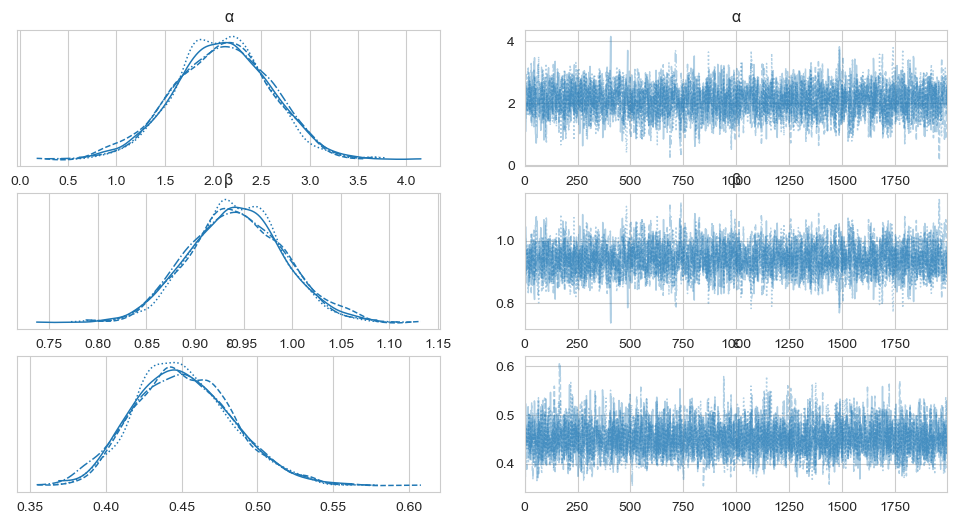

In [6]:
with pm.Model() as model_gm:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfNormal('ε', 10)
    
    y_pred = pm.Normal('y_pred', mu= α + β * x, sigma=ε, observed=y)
    
    trace_gm = pm.sample(2000,tune=1000, chains=4, cores=4) 
    # ошибки можно попробовать компенсировать увеличением tune для улучшения подбора параметров

az.plot_trace(trace_gm, var_names=['α', 'β', 'ε']);
az.summary(trace_gm).head(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.102,0.499,1.158,3.031,0.011,0.007,2251.0,2389.0,1.0
β,0.942,0.049,0.852,1.034,0.001,0.001,2255.0,2352.0,1.0
ε,0.450,0.032,0.395,0.517,0.001,0.000,3176.0,3071.0,1.0


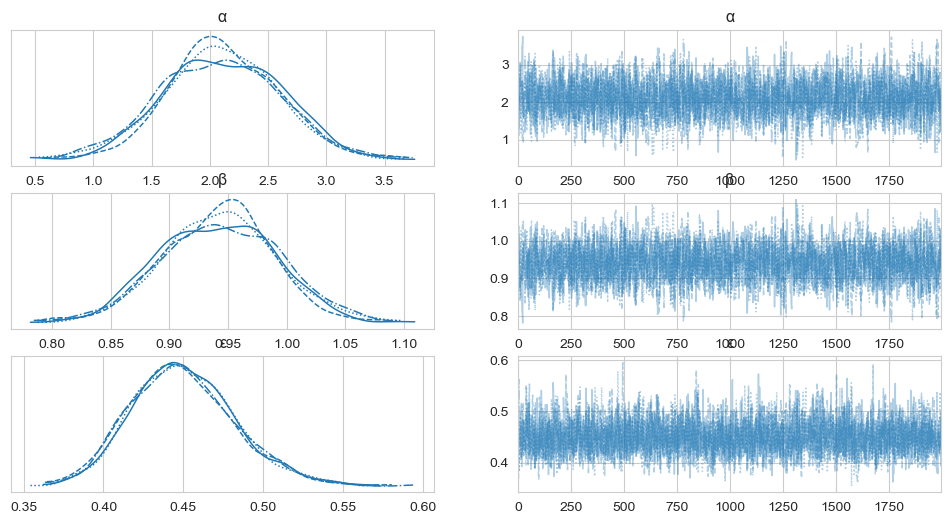

In [7]:
with pm.Model() as model_gc:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfCauchy('ε', 10)
    
    y_pred = pm.Normal('ypred', mu= α + β * x, sigma=ε, observed=y)
    
    trace_gc = pm.sample(tune=2000, draws = 2000, chains=4, cores=4)
az.plot_trace(trace_gc, var_names=['α', 'β', 'ε']);
az.summary(trace_gc).head(3)

### Корреляция апостериорных распределений

Использование линейных моделей приводит к апостериорному распределению, где $\alpha$ и $\beta$ тесно взаимосвязаны, то есть между ними существует сильная корреляция.

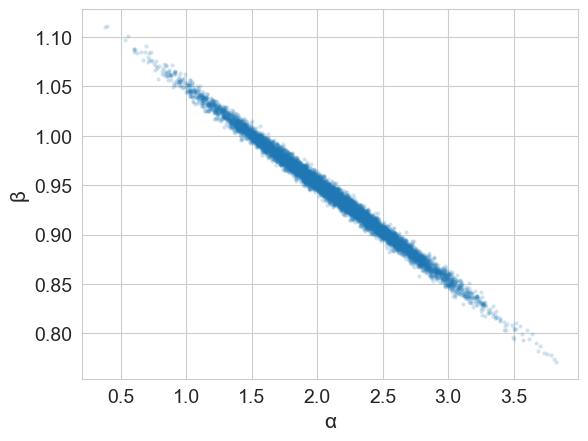

In [8]:
az.plot_pair(trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.2});

Корреляция, наблюдаемая на cхеме, является прямым следствием наших предположений:<br>
не имеет значения, какая из линий полностью соответствует исследуемым данным, все они должны проходить через одну точку, то есть через среднее значение переменной $x$ и среднее значение переменной $y$. Следовательно, процесс подгонки линии в некоторой степени равнозначен вращению прямой линии, закрепленной в центре данных.

Увеличение угла наклона означает уменьшение области пересечения, и наоборот. Оба параметра взаимосвязаны (коррелируют) по определению используемой модели. Таким образом, форма апостериорного распределения (исключая $ $) представляет собой "диагональное пространство". Это может быть проблемой для сэмплеров, таких как алгоритм Метрополиса–Гастингса, или в гораздо меньшей степени для NUTS. Если хватит времени мы поговорим об этом.

Тот факт, что для линии установлено ограничивающее условие прохождения через точку, соответствующую среднему значению данных, <b>является истинным только для метода наименьших квадратов</b> (и соответствующих предварительных предположений). <br>
При использовании байесовских методов это ограничение ослабляется. В следующих примерах мы увидим, что в общем случае линии располагаются в непосредственной близости от средних значений $x$ и $y$, а не в точности проходят через точку, соответствующую средним значениям $x$ и $y$. <br>
Тем не менее общее представление о том, что автокорреляция связана с линией, вращающейся относительно более или менее определенной точки, остается истинным, следовательно, необходимо лишь понять степень корреляции между параметрами $\alpha$ и $\beta$.

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [α]
>Metropolis: [β]
>Metropolis: [ε]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.822,0.644,0.712,2.852,0.309,0.235,5.0,31.0,1.69
β,0.970,0.063,0.866,1.075,0.030,0.023,5.0,31.0,1.69
ε,0.452,0.033,0.394,0.515,0.001,0.001,995.0,999.0,1.01


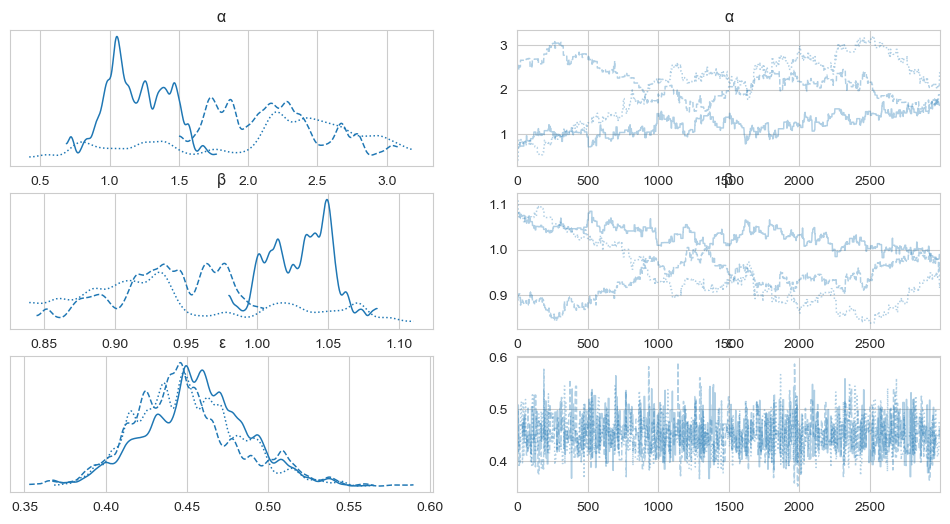

In [9]:
with pm.Model() as model_m:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y)
    trace_m = pm.sample(3000, tune=1000, step = pm.Metropolis() )
    
az.plot_trace(trace_m, var_names=['α', 'β', 'ε']);
az.summary(trace_m).head(3)

Решение лежит в стандартизации:

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [α]
>Metropolis: [β]
>Metropolis: [ε]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.045,-0.084,0.081,0.001,0.001,1379.0,1493.0,1.0
β,0.891,0.046,0.810,0.984,0.001,0.001,1929.0,1884.0,1.0
ε,0.458,0.032,0.397,0.518,0.001,0.001,1909.0,2044.0,1.0


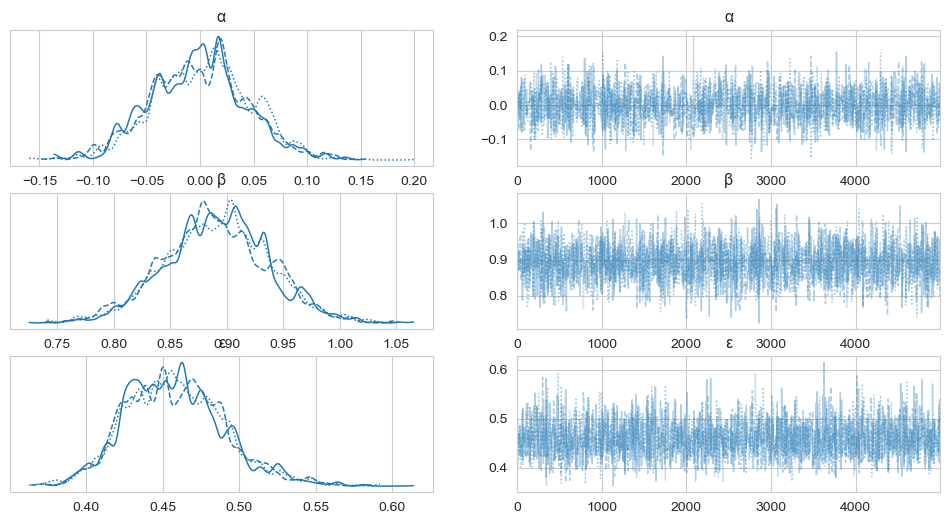

In [10]:
xm = x.mean()
xs = x.std()
ym = y.mean()
ys = y.std()

with pm.Model() as model_m:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * (x-xm)/xs  )
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=(y-ym)/ys)
    trace_m = pm.sample(5000, step = pm.Metropolis() )
    
az.plot_trace(trace_m, var_names=['α', 'β', 'ε']);
az.summary(trace_m).head(3)

<b>Вопрос:</b> как вернуть истинное значение параметра $\alpha$ ?

### Исследуем апостериорное распределение

Для линейной регрессии может оказаться полезным построение средней линии, соответствующей данным, вместе с усредненными средними значениями $\alpha$ и $\beta$. 
Для отображения неопределенности апостериорного распределения можно использовать полупрозрачные линии, отображающие выборки из апостериорного распределения:

всего трасс :  8000


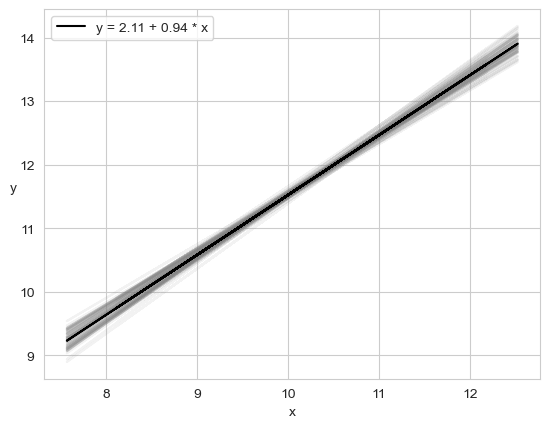

In [11]:
posterior_g = az.extract(trace_g)


alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(x, posterior_g['α'][draws].values + 
                 posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.1)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

Внимание! Неопределенность меньше в средней части графика, хотя и не сходится к одной точке, то есть апостериорное распределение совмещается с линиями, не проходящими в точности через среднее значение данных, как уже было сказано выше.

Давайте используем ПАР (плотность апостериорного распределения) для отображения нашего результата:

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


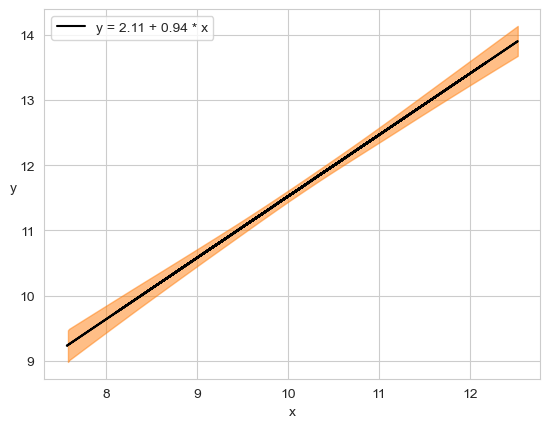

In [12]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, posterior_g['μ'].T, hdi_prob=0.94)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend();


А теперь построим прогнозы:

In [13]:
ppc = pm.sample_posterior_predictive(trace_g, model=model_g)

Sampling: [y_pred]


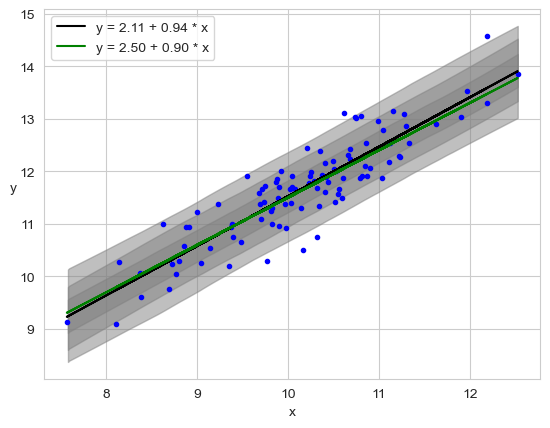

In [14]:
# Пример тройного вложения полос
ax0 = az.plot_hdi(x, ppc.posterior_predictive['y_pred'], color='gray')#, smooth=False)
ax1 = az.plot_hdi(x, ppc.posterior_predictive['y_pred'], ax=ax0, hdi_prob=0.8, color='gray') # smooth=False
az.plot_hdi(x, ppc.posterior_predictive['y_pred'], ax=ax1, hdi_prob=0.5, color='gray')  # smooth=False

plt.plot(x, y, '.', color = 'blue')
plt.plot(x, alpha_m + beta_m * x, c='k',
            label = f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.plot(x, alpha_real + beta_real * x, c='green',
            label = f'y = {alpha_real:.2f} + {beta_real:.2f} * x')

plt.xlabel('x'); 
plt.ylabel('y', rotation=0);
plt.legend();

### Качество модели

$R^2$

In [15]:
y

array([11.90975697, 12.29617873, 11.5990566 , 11.49773636, 10.94728315,
       10.50167484, 13.03890669, 10.26106601, 11.41992289, 11.4046679 ,
       10.99524838, 10.7535731 , 12.10033598, 10.53440848, 12.3823761 ,
        9.7689993 , 11.37895994,  9.60687567, 12.53038281, 12.15941809,
       10.92753515, 11.3747164 , 13.0971757 , 13.52163874, 10.2782443 ,
       12.2706837 , 12.90344057, 11.33632581, 10.28671473, 12.54218852,
       10.99134135, 10.75809467, 10.04936133, 11.57288093, 11.87790311,
       10.93249004, 11.40986353, 10.5873006 , 13.05157602, 11.91293265,
       11.23616943, 10.96461423, 11.90841839, 13.02159778, 12.00192267,
       11.30543327, 11.66549676, 13.1066698 , 11.76932458, 12.42289782,
       11.37098006,  9.13252109, 11.86368304, 13.29361032, 11.79278088,
       11.70317189, 11.79669144, 11.85840227, 11.65846213, 10.93275373,
       10.65741602, 11.22910993, 11.98038416, 11.08397655, 12.18994926,
       11.3049813 , 12.95351636, 12.45208892, 14.56441746,  9.09

In [16]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

In [17]:
az.extract(ppc, group="posterior_predictive", var_names="y_pred").values.T # shape

array([[10.92382531, 12.66115383, 10.65962719, ..., 12.10250916,
        12.34546002, 12.06042907],
       [10.98248773, 12.03820416, 11.73158618, ..., 11.75999693,
        12.40507269, 12.24589809],
       [10.57956385, 12.63460153, 12.41119886, ..., 11.60790395,
        12.26535372, 12.40535327],
       ...,
       [11.15358003, 12.68659048, 11.83989029, ..., 12.35526948,
        13.14703578, 13.17200049],
       [11.28238952, 13.19527061, 11.51713599, ..., 12.8719461 ,
        12.70062892, 13.00993797],
       [10.92282002, 13.66615959, 12.08451045, ..., 12.42558927,
        12.64029371, 12.75400094]])

In [18]:
az.r2_score(y, az.extract(ppc, group="posterior_predictive", var_names="y_pred").values.T)

r2        0.709299
r2_std    0.034389
dtype: float64

## Робастная модель

Предположение о том, что данные подчиняются нормальному распределению, абсолютно обосновано во многих ситуациях. Говоря о предполагаемой «нормальности», мы не обязательно подразумеваем, что распределение данных действительно является нормальным, а всего лишь допускаем, что это разумная аппроксимация поставленной задачи. То же самое можно сказать и о других распределениях.

Иногда предположение о гауссовом распределении является ошибочным, например при наличии промахов. Мы узнали, что применение распределения Стьюдента представляет собой эффективный способ обработки промахов и обеспечивает более надежный статистический вывод. Этот же принцип можно применять и для линейной регрессии.

Приведем пример, на основе третьей задачи из квартета Энскоба (https://ru.wikipedia.org/wiki/Квартет_Энскомба). 

Загрузим данные из Seaborn

In [19]:
df = sns.load_dataset("anscombe")
x = df[df.dataset=="III"].x.values
y = df[df.dataset=="III"].y.values

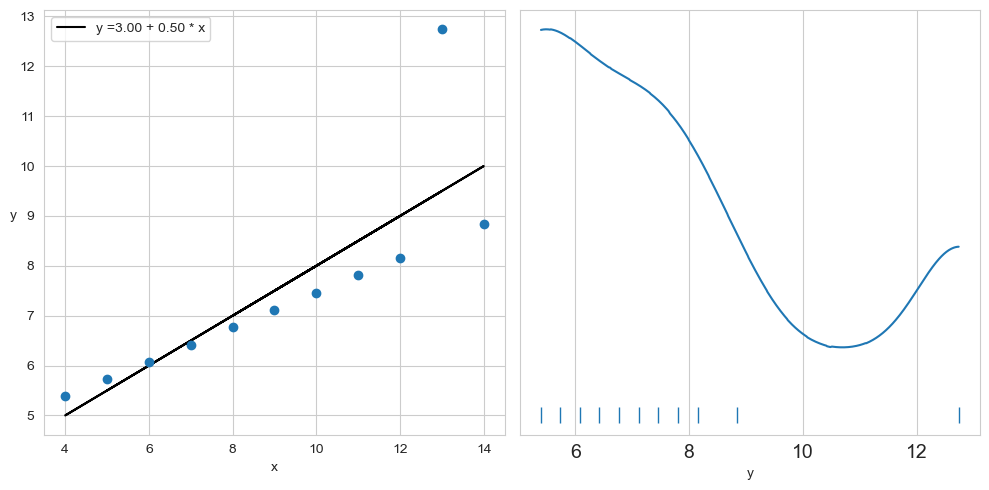

In [20]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x, y)[:2]
ax[0].plot(x, (alpha_c + beta_c * x), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x, y, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

Далее перепишем предыдущую модель (model_g), но на этот раз воспользуемся распределением Стьюдента вместо нормального распределения. Это изменение также приводит к необходимости определения значения $\nu$, параметра нормальности. 

Далее в модели используется экспоненциальный сдвиг, чтобы избежать значений $\nu$, близких к нулю. Без экспоненциального сдвига наблюдается слишком большой вес значений, близких к нулю.

Принято использовать для данных без смягчения промахов близкие к нулю значения, а для данных с экстремальными промахами, такими как третий набор квартета Энскомба, лучше избегать слишком малых значений.

Для облегчения работы сэмплера не забываем центрировать переменые!!!

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_tmp, β, ε, ν_]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


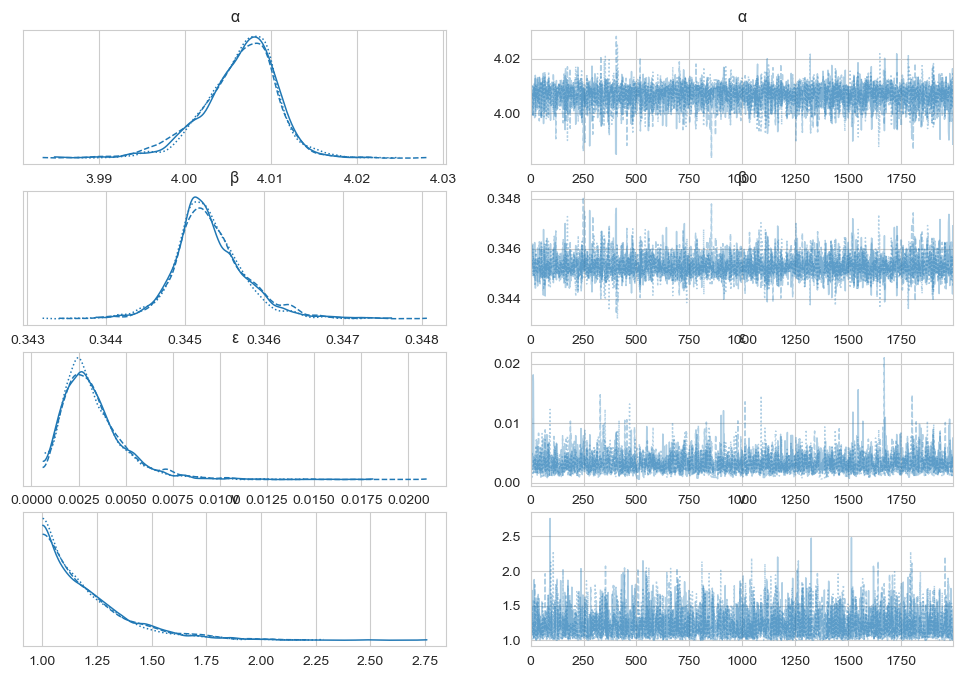

In [21]:
x_centered = x - x.mean()

with pm.Model() as model_t:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) # а можно брать mu= y.mean() sd = 1
    β = pm.Normal('β', mu=0, sigma=10)
    ε = pm.HalfNormal('ε', 5)                         # \varepsilon<Tab>
    ν_ = pm.Exponential('ν_', 1/30)
    #ν_ = pm.Gamma('ν_', 2, 0.1)
    #ν_ = pm.Gamma('ν_', mu=20, sd=15)
    ν = pm.Deterministic('ν', ν_+1) # экспоненциальный сдвиг 
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp + β * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())
    
    trace_t = pm.sample(2000, chains=3)

varnames = ['α', 'β', 'ε', 'ν']
az.plot_trace(trace_t, var_names=varnames);

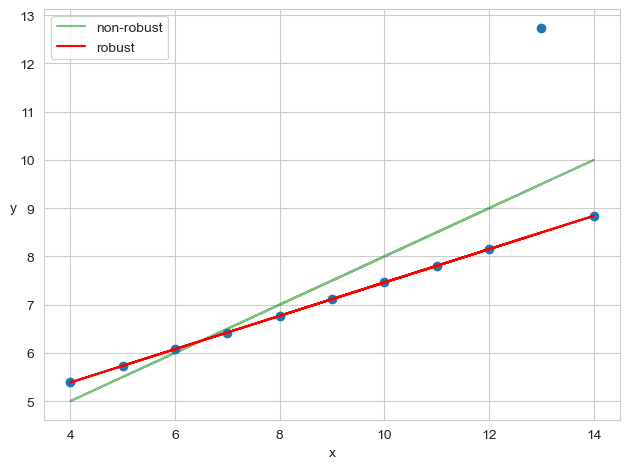

In [22]:
beta_c, alpha_c = stats.linregress(x, y)[:2]

plt.plot(x, (alpha_c + beta_c * x), 'green', label='non-robust', alpha=0.5)
plt.plot(x, y, 'C0o')

posterior_mean = az.extract(trace_t).mean()

alpha_m = posterior_mean['α'].item()
beta_m  = posterior_mean['β'].item()

plt.plot(x, alpha_m + beta_m * x, c='red', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

Линия неробастной подгонки пытается найти компромисс для включения всех точек данных, в то время как робастная байесовская модель model_t автоматически отбрасывает одну точку и создает линию, которая точно проходит через все остальные точки. 

Очевидно, что исследуемый в примере набор данных весьма специфический, но полученный результат остается справедливым и для более сложных реальных наборов данных. Благодаря своему более медленно убывающему (более широкому) хвосту распределение Стьюдента способно снижать значимость точек, которые расположены слишком далеко от основного массива данных.

Давайте оценим наши результаты.

In [23]:
az.summary(trace_t, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,4.006,0.004,3.998,4.013,0.000,0.000,3622.0,2831.0,1.0
β,0.345,0.000,0.344,0.346,0.000,0.000,3500.0,2752.0,1.0
ε,0.003,0.002,0.001,0.006,0.000,0.000,1809.0,907.0,1.0
ν,1.209,0.198,1.000,1.574,0.003,0.002,2415.0,1578.0,1.0


Можно видеть, что значения $\alpha$, $\beta$ и $\varepsilon$ находятся в чрезвычайно узком интервале и в наибольшей степени это относится к параметру $\varepsilon$, который в большинстве случаев равен 0. Это абсолютно обосновано с учетом того, что выполняется подгонка линии к идеально выровненному набору точек данных (если исключить точку промаха).

Выполним проверку прогнозируемого апостериорного распределения, чтобы узнать, насколько эффективно наша модель обрабатывает данные:

In [24]:
pm.sample_posterior_predictive(trace_t, model=model_t, random_seed=42, extend_inferencedata=True)

Sampling: [y_pred]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

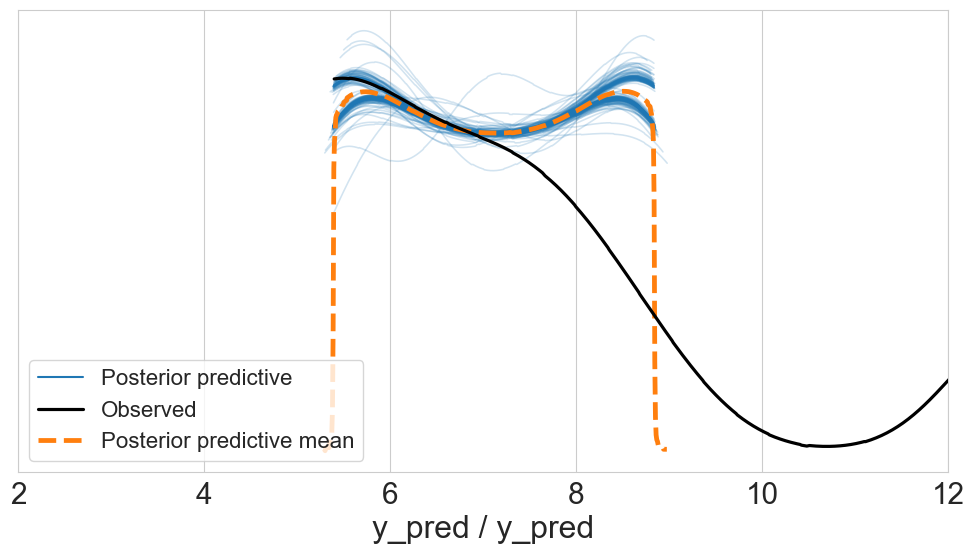

In [25]:
ax = az.plot_ppc(trace_t, num_pp_samples=200, figsize=(12, 6), mean=True)
plt.xlim(2, 12);

Для основной части данных наблюдается очень хорошее соответствие.  Для наших текущих целей эта модель работает эффективно и не требует дальнейших изменений.